In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

### Andmete laadimine

In [4]:
with open("../config/marc_columns_to_keep.json", "r", encoding="utf8") as f:
    columns = json.load(f)["columns"]

with open("../config/marc_columns_dict.json", "r", encoding="utf8") as f:
    column_names = json.load(f)
    column_names_reverse = {val: key for key, val in column_names.items()}
    column_names_verbose = {key: f"{key}: {val}" for key, val in column_names.items()}

In [5]:
df_main = pd.read_csv("../data/interim/erb_books.tsv", sep="\t", encoding="utf8")

C:\Users\krister.kruusmaa\AppData\Local\Temp\ipykernel_22544\2810970634.py:1: DtypeWarning: Columns (4,27,61,66,84,90,92,93,94,95,96,97,98,99,100,101,102,103,104,105,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv("../data/interim/erb_books.tsv", sep="\t", encoding="utf8")


In [6]:
df_main = df_main[columns]
df_main.head()

,001,020$a,041$a,041$h,080$a,100,245$a,245$b,245$n,246$a,...,655$a,655$0,700,710$a,710$b,740$a,752$c,752$d,776$i,856$u
0,b10500820,9789916099896,NaN,NaN,821.511.113-31,"Tammsaare, A. H (1878-1940) [autor]",Tõde ja õigus,romaan,1. [kd.],NaN,...,ilukirjandus (vormimärksõna); romaanid (vormim...,https://ems.elnet.ee/id/EMS002472; https://ems...,"Eelma, Herald (1934-) [illustreerija]",NaN,NaN,NaN,NaN,NaN,NaN,http://www.digar.ee/id/nlib-digar:829637
1,b10258747,9186116800,NaN,NaN,94; 355.48,"Laar, Mart (1960-) [autor]",Isamaa ilu hoieldes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b10501915,9789916015346,NaN,NaN,17.036; 141.82,"Makarov, Mihhail (1922-2019) [autor]",Eesmärk ja vahendid,NaN,NaN,NaN,...,NaN,NaN,"Tali, Erich (1921-1990) [kujundaja]",NaN,NaN,NaN,NaN,NaN,NaN,http://www.digar.ee/id/nlib-digar:447419
3,b10509884,5450023782,est,eng,821.111,"Buck, Pearl S (1892-1973) [autor]",Ema,romaan,NaN,Mother,...,ilukirjandus (vormimärksõna); romaanid (vormim...,https://ems.elnet.ee/id/EMS002472; https://ems...,"Hanko, August (1879-1952) [tõlkija]; Linnamägi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b10505283,5440008519,est,NaN,581.9; 591.9; 913,NaN,Ruhnu saare loodus =,Nature of the Ruhnu island = Природа острова Р...,NaN,Nature of the Ruhnu island; Природа острова Рухну,...,artiklikogumikud (vormimärksõna),https://ems.elnet.ee/id/EMS026849,"Talvi, Tõnu (1962-) [toimetaja]",Eesti Looduseuurijate Selts,NaN,NaN,NaN,NaN,NaN,NaN


### Abifunktsioonid

In [7]:
def roman_to_arabic(roman):
    # Mapping of Roman numerals to Arabic numerals
    roman_numerals = {
        'I': 1,
        'V': 5,
        'X': 10,
        'L': 50,
        'C': 100,
        'D': 500,
        'M': 1000
    }
    
    # Initialize the previous value and total
    prev_value = 0
    total = 0
    
    # Reverse the Roman numeral string for left-to-right calculation
    for char in reversed(roman):
        value = roman_numerals[char]
        
        # If the current value is less than the previous one, subtract it from the total; else add it
        if value < prev_value:
            total -= value
        else:
            total += value
        
        # Update the previous value
        prev_value = value
    
    return total

In [8]:
def missing_values_heatmap(df, verbose=True):
    plt.figure(figsize=(6,4))
    df_hm = df.copy()
    if verbose:
        df_hm = df_hm.rename(columns=column_names_verbose)

    print("Täidetus:")
    for col in df_hm.columns:
        print(f"{col}: {round((df_hm[col].notna().sum()/len(df_hm))*100)} %")
    sns.heatmap(df_hm.isna(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title("Puuduvad väärtused")
    plt.show()

In [181]:
def regex_coverage(df, col, pattern):
    total_entries = len(df.loc[df[col].notna()])
    covered_values = 0
    for entry in df.loc[df["300$a"].notna(), "300$a"].values:
        if re.search(pattern, entry):
            covered_values += 1

    print(f"Regex katab {covered_values} kirjet {total_entries} kirjest")
    print("Kaetus: ", round(covered_values/total_entries*100, 2), "%")

## Tulpade analüüs ja puhastamine

#### Pealkiri ja alapealkiri (245 a, b, n)

In [24]:
### vaatame üle nende tulpade kaetuse

df = df_main[["245$a", "245$b", "245$n"]].copy()

Täidetus:
245$a: title: 100 %
245$b: title_remainder: 54 %
245$n: title_part_nr: 8 %


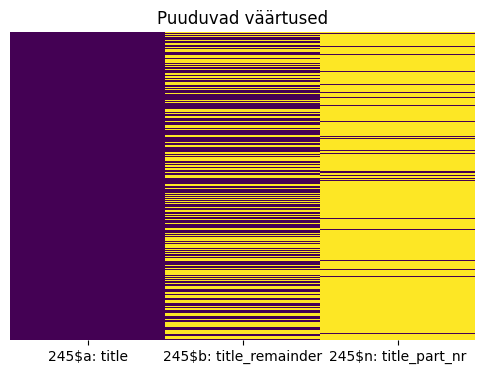

In [13]:
missing_values_heatmap(df)

In [409]:
### OTSUS: ühtlustada 245$n regexi abil

In [27]:
# võtame 2000 sagedasemat väärtust
sample_values = df["245$n"].value_counts()[:2000].index

In [28]:
# regex pattern
pattern_245n = r"(?:([Nn]r\.?\s)|Album\s|Triloogia\s)?(?P<n>(?P<araabia>\d{1,2})|(?P<rooma>\b(?=[MDCLXVI]+\b)(M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3}))\b)|(?P<arvsna>(?P<a1>[Ee]{1,2}[sd]{1,2}i?m[eaä]n{1,2}e)|(?P<a2>[Tt][eõö]ine)|(?P<a3>[Kk]olmas)|(?P<a4>[Nn]eljas)|(?P<a5>[VWvw]i{1,2}es)|(?P<a6>[Kk]u{1,2}es)|(?P<a7>[Ss]eitsmes)|(?P<a8>[Kk]ah{1,2}eksas)|(?P<a9>[Üü]h{1,2}eksas)|(?P<a11>([Üü](ks|he)teist)|(?P<a12>[Kk]a(ks|he)teist))?(?P<a10>[Kk]ümnes))|(?P<AB>A|B))(\.)?\s?(?P<p>(?:\[?)([A-zöõäü]+)(?:\.?\]?))?"

In [29]:
# katsetame kaetuse protsenti
print(f"Regex katab {df['245$n'].value_counts()[:2000].sum()} kirjet {len(df.loc[df['245$n'].notna()])} kirjest")
print("Kaetus: ", round((df["245$n"].value_counts()[:2000].sum()/len(df.loc[df["245$n"].notna()]))*100, 2), "%")

Regex katab 18029 kirjet 18088 kirjest
Kaetus:  99.67 %


In [31]:
# millised jäävad katmata?

for entry in sample_values:
    match = re.search(pattern=pattern_245n, string=entry)
    if match:
        # print("\n")
        # print(entry)
        # print(match.groupdict())
        pass
    else:
        print(entry)

Lisaköide
Lõpuosa
Lisa
Täiendusköide
Lisavihik
Liber quartus
Nelli ramatut
First book
Третья часть
Valdkond H
Valdkond G
Valdkond F
Рабочая тетрадь "Б"
Девятый созыв : краткий биографический справочник
Рабочая тетрадь А
Lisad
Üldosa
Eriväljaanne
E


In [32]:
def clean_245n(entry: str, pattern=pattern_245n):
    
    if type(entry) == str:
        match = re.search(pattern, entry)
        if match:
            groups = match.groupdict()
            n = None
            p = None

            if groups["n"]:
                if groups["araabia"]:
                    n = groups["araabia"]
                elif groups["rooma"]:
                    n = str(roman_to_arabic(groups["rooma"]))
                elif groups["arvsna"]:
                    for key, val in groups.items():
                        if re.search("a\d{1,2}", key):
                            if val is not None:
                                n = key.lstrip("a")
                                break
                elif groups["AB"]:
                    if groups["AB"] == "A":
                        n = "1"
                    elif groups["AB"] == "B":
                        n = "2"
                    
            if groups["p"]:
                p = f" [{groups['p'].lstrip('[').strip(']')}]"
            else:
                p = ''

            #print(groups)
            return n+p

In [62]:
# näited
sample = df["245$n"].loc[df["245$n"].notna()].sample().values[0]
print(sample, "\t-\t", clean_245n(sample, pattern_245n))

1 ja 2 	-	 1 [ja]


**TODO**: 1-3, III-IV jne, I ja II, 3 ja 4

### Koht, aeg, kirjastus dubleerimise kaotamine (260 vs 264)

**Probleem**: mingil hetkel 2022. aasta jooksul hakati 260 asemel kasutama 264.

In [874]:
df = df_main[["260$a", "260$b", "260$c", "264$a", "264$b", "264$c"]].copy()

Täidetus:
260$a: publication_place: 96 %
260$b: publisher: 95 %
260$c: publication_date: 96 %
264$a: production_publication_distribution_place: 4 %
264$b: producer_publisher_distributer_name: 4 %
264$c: production_publication_distribution_date: 4 %


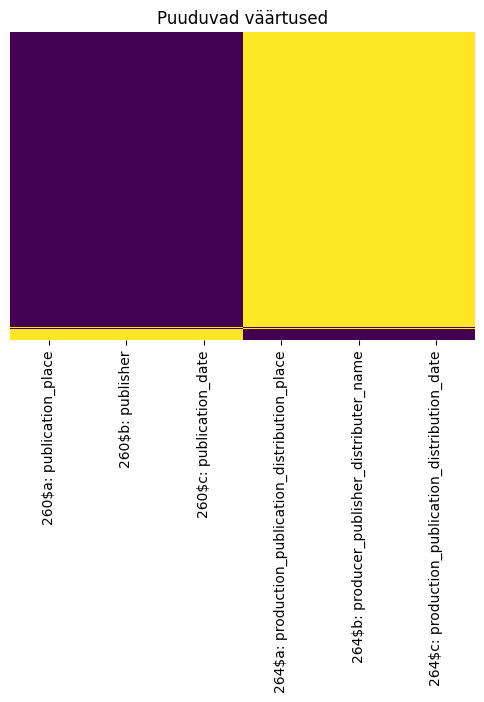

In [875]:
missing_values_heatmap(df)

In [876]:
### igaks juhuks topelkontroll, ega pole kirjeid, kus on täidetud nii 260 kui 264

for sub in ["a", "b", "c"]:
    rows_with_values_in_both_columns = df[df[f'260${sub}'].notna() & df[f'264${sub}'].notna()]
    print("260", sub, "topeltkirjete arv:", len(rows_with_values_in_both_columns))

260 a topeltkirjete arv: 0
260 b topeltkirjete arv: 0
260 c topeltkirjete arv: 0


In [877]:
### kuna väärtus on alati kas ainult 260 või 264 peal, siis jääb üle need lihtsalt kokku tõsta. Jätame alles väljad 260 ja täiendame neid väljadega 264
def add_260abc_264abc(df):
    for sub in ["a", "b", "c"]:
        df[f"260${sub}"] = df[f"260${sub}"].fillna(df[f"264${sub}"])

add_260abc_264abc(df)

### Aastaarvude puhastamine (260c)

In [818]:
# peab tegelema sellist sorti eranditega
yr = df["260$c"].copy()
yr = yr[yr.notna()]
for i in yr[~yr.str.contains(r"^\d{4}$", na=False)].sample(10):
    print(i)

c2019
2023; ©2023
1906?
c2015
c2009
c2003
c2007
c2005
c2016
c2021


In [819]:
pattern_260c = re.compile(r"(?:c|(?P<copyright>©)|tsens(eeritud|\.)\s*)?((?P<year>\d{4})(?:\.0)?(?:\?)?|(?P<decade>\d{3}-\?)|(?P<century>\d{2}--\?))")

In [820]:
def clean_260c(entry, pattern=pattern_260c, min_year=1500, max_year=2024):
    """Funktsioon võtab sisse välja 260$c ehk ilmumisaasta kirje ning tagastab aasta ning kümnendi arvulisel kujul."""
    output_year = None
    output_decade = None
    # output_century = None

    if type(entry) != str:
        entry = str(entry)

    # 2022; 2022    
    if ";" in entry:
        entry_split = entry.split("; ")
        years = []
        for part in entry_split:
            match = re.search(pattern, part)
            if match:
                part_year = match.groupdict()["year"]
                if part_year is not None:
                    if part_year not in years:
                        if match.groupdict()["copyright"] is None:
                            years.append(part_year)
                        else:
                            if len(years) == 0:
                                years.append(part_year)

        if len(years) == 1:
            output_year = int(years[0])
        else:
            output_year = min([int(y) for y in years])

    else:
        match = re.search(pattern, entry)
        if match:
            groups = match.groupdict()
            # 2022
            if groups["year"] is not None:
                output_year = int(groups["year"])
            # 196-?
            elif groups["decade"] is not None:
                output_decade = int(groups["decade"].strip("?").replace("-", "0"))
            # 18--?
            # elif groups["century"] is not None:
            #     output_century = int(groups["century"].strip("?").replace("-", "0"))

    if output_year:
        if output_year in range(min_year, max_year+1):
            output_decade = output_year // 10 * 10
            # output_century = output_year // 100 * 100
        else:
            output_year = None

    # elif output_decade:
    #     output_century = output_decade // 10 * 10

    return (output_year, output_decade)


In [821]:
df[["260$c_cleaned", "decade"]] = df["260$c"].apply(clean_260c).to_list()
df = df.convert_dtypes()

In [867]:
df[["260$c", "260$c_cleaned", "decade"]].sample(10)

,260$c,260$c_cleaned,decade
219149,2023,2023,2020
59711,2000,2000,2000
52896,1980,1980,1980
199027,2019,2019,2010
68548,1968,1968,1960
109583,1942,1942,1940
110640,1860,1860,1860
14588,1932,1932,1930
152418,2008,2008,2000
114482,c2002,2002,2000


In [872]:
# ebastandardsemaid näiteid
sample = yr[~yr.str.contains(r"^\d{4}$", na=False)].sample(10)
cleaned_sample = sample.apply(clean_260c)

for s, c in zip(sample, cleaned_sample):
    print(s, "\t\t", c)

c2018 		 (2018, 2010)
c2007 		 (2007, 2000)
c2003 		 (2003, 2000)
c2005 		 (2005, 2000)
c2002 		 (2002, 2000)
c2017 		 (2017, 2010)
c2017 		 (2017, 2010)
c2011 		 (2011, 2010)
c2020 		 (2020, 2020)
c2013 		 (2013, 2010)


In [871]:
# millised jäävad katmata?
for val in df["260$c"].values:
    val_cleaned = clean_260c(val)
    if val_cleaned == (None, None):
        if val is not None:
            print(val, "\t\t", val_cleaned)
# nagu näha, siis need, mis on vaid sajandi täpsusega (19--?), ja vigased kanded

19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
18--? 		 (None, None)
19--? 		 (None, None)
J. Felsberg ja A. Tetermann 		 (None, None)
J. F. Steffenhagen und Sohn 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
18--? 		 (None, None)
19--? 		 (None, None)
18--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
1291 [p.o. 1921] 		 (None, None)
1291 [p.o. 1921] 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
Tallinn 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
[19--?] ( 		 (None, None)
19--? 		 (None, None)
19--

### 3. Füüsilised omadused (300 a, b, c)

In [151]:
df = df_main[["300$a", "300$b", "300$c"]].copy()

Täidetus:
300$a: physical_extent: 99 %
300$b: physical_details: 53 %
300$c: physical_dimensions: 90 %


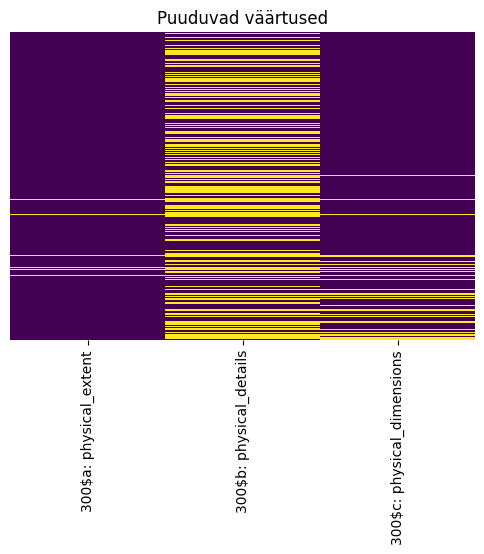

In [153]:
missing_values_heatmap(df)

In [407]:
### kuna tegu on väga hästi täidetud tulpadega, võiks need regexiga ära puhastada ja vajadusel eraldi tulpadeks lahku lüüa

#### 300$a

In [274]:
### teeme sellest tulbast konkreetselt lehekülgede arvu tulba, st võtame välja lk arvu seal, kus võimalik. e-raamatud ja võrguväljaanded jätame hetkel kõrvale.
df["300$a"].value_counts()[:10]

1 võrguväljaanne (epub)    5165
16 lk                      3010
32 lk                      2621
1 võrguressurss (epub)     2349
1 e-raamat                 2254
64 lk                      1947
24 lk                      1829
48 lk                      1795
8 lk                       1491
96 lk                      1447
Name: 300$a, dtype: Int64

In [173]:
pattern_300a = re.compile(r"(?P<arv>\[?\d{1,4}\]?),?(\s*)?(?P<sulud>\[\d+\])?\s+(?P<uhik>lk|l\b|(nummerdamata\s)?lehekülge|voldik|CD-ROM|(võrgu(väljaanne|ressurss)|e-raamat))")

In [183]:
# testime kaetust
regex_coverage(df, "300$a", pattern_300a)

Regex katab 214366 kirjet 216836 kirjest
Kaetus:  98.86 %


In [185]:
# millised jäävad katmata?
sample_values = df["300$a"].value_counts()[:200].index
for entry in sample_values:
    match = re.search(pattern=pattern_300a, string=entry)
    if match:
        print("\n")
        print(entry)
        print(match.groupdict())
        pass
    else:
        print(entry)



1 võrguväljaanne (epub)
{'arv': '1', 'sulud': None, 'uhik': 'võrguväljaanne'}


16 lk
{'arv': '16', 'sulud': None, 'uhik': 'lk'}


32 lk
{'arv': '32', 'sulud': None, 'uhik': 'lk'}


1 võrguressurss (epub)
{'arv': '1', 'sulud': None, 'uhik': 'võrguressurss'}


1 e-raamat
{'arv': '1', 'sulud': None, 'uhik': 'e-raamat'}


64 lk
{'arv': '64', 'sulud': None, 'uhik': 'lk'}


24 lk
{'arv': '24', 'sulud': None, 'uhik': 'lk'}


48 lk
{'arv': '48', 'sulud': None, 'uhik': 'lk'}


8 lk
{'arv': '8', 'sulud': None, 'uhik': 'lk'}


96 lk
{'arv': '96', 'sulud': None, 'uhik': 'lk'}


20 lk
{'arv': '20', 'sulud': None, 'uhik': 'lk'}


40 lk
{'arv': '40', 'sulud': None, 'uhik': 'lk'}


80 lk
{'arv': '80', 'sulud': None, 'uhik': 'lk'}


15 lk
{'arv': '15', 'sulud': None, 'uhik': 'lk'}


56 lk
{'arv': '56', 'sulud': None, 'uhik': 'lk'}


12 lk
{'arv': '12', 'sulud': None, 'uhik': 'lk'}


1 võrguväljaanne (pdf)
{'arv': '1', 'sulud': None, 'uhik': 'võrguväljaanne'}


15, [1] lk
{'arv': '15', 'sulud': '[1]'

In [255]:
def clean_300a(entry: str, pattern=pattern_300a):
    
    if type(entry) == str:
        match = re.search(pattern, entry)
        if match:
            groups = match.groupdict()
            lk = None

            if groups["arv"]:
                if groups["uhik"]:
                    if groups["uhik"] in ["l", "lk", "lehekülge", "nummerdamata lehekülge"]:
                        lk = int(groups["arv"].lstrip("[").strip("]"))

            # print(groups)
            return lk

In [256]:
# näited
sample = df["300$a"].loc[df["300$a"].notna()].sample().values[0]
print(sample, "\t-\t", clean_300a(sample, pattern_300a))

[48] lk 	-	 48


In [262]:
df["300$a_cleaned"] = df["300$a"].apply(clean_300a)
df = df.convert_dtypes()

In [268]:
df.sample(10)

,300$a,300$b,300$c,300$a_cleaned
191570,1 e-raamat (epub),<NA>,<NA>,<NA>
74738,"Lk. 206-275, [1]",joon,20 cm,<NA>
175495,51 lk,<NA>,23 cm,51
184394,"1 võrguväljaanne (54 lk., pdf)",ill,<NA>,<NA>
145531,"191, [1] lk",<NA>,21 cm,191
134634,"283, [5] lk",ill,25 cm,283
42169,82 lk,<NA>,14 cm,82
161342,"[16] lk., [2] l. kleeppilte, [2] l. kujundeid",ill,27 cm,16
32155,"134, [1] lk",<NA>,20 cm,134
34103,119 lk,ill,20 cm,119


#### 300$b

In [275]:
### tundub, et selle tulba võib teha lihtsalt 1/0 tulbaks - kui midagi on märgitud, siis on raamat illustreeritud
df["300$b"].value_counts()[:10]

ill                 80868
ill., portr         10670
ill. kaas            4182
illustratsioonid     3940
portr                2664
ill., ill. kaas      2582
ill., kaart          2185
joon                  977
fot                   916
ill., noot            740
Name: 300$b, dtype: Int64

In [276]:
def clean_300b(entry):
    if type(entry) == str:
        return True
    else:
        return False

In [278]:
df["300$b_cleaned"] = df["300$b"].apply(clean_300b)

In [281]:
df.sample(10)

,300$a,300$b,300$c,300$a_cleaned,300$b_cleaned
118166,"15, [1] lk",<NA>,21 cm,15,False
18026,149 lk,<NA>,24 cm,149,False
107106,16 lk,<NA>,17 cm,16,False
76699,12 lk,<NA>,14 cm,12,False
68838,78 lk,ill,20 cm,78,True
157674,36 lk,ill,24 cm,36,True
166416,32 lk,ill,30 cm,32,True
13220,"62, [3] lk. koos kaanega",ill,21 cm,62,True
109430,94 lk,<NA>,21 cm,94,False
163033,[10] lk,ill,16 cm,10,True


#### 300$c

In [292]:
### proovime kätte saada sentimeetrid, mis juhendi järgi tähendavad raamatu kõrgust
df["300$c"].loc[df["300$c"].notna()].sample(10)

108481      21 cm
27367       21 cm
7394        22 cm
63989       15 cm
129787      25 cm
173545      21 cm
214288      23 cm
149845      22 cm
59991       20 cm
58025     22 cm +
Name: 300$c, dtype: string

In [361]:
def clean_300c(entry):
    if type(entry) == str:
        entry = entry.strip().lstrip()
        # formaat NN cm
        if re.match("\d{1,3}\s?cm", entry):
            entry = entry.split("cm")[0].strip()
        # kataloogimisviga cm -> cn
        elif re.match("\d{1,3}\s?cn", entry):
            entry = entry.split("cn")[0].strip()
        # kahe mõõdu (NN x NN cm) puhul võtame esimese arvu, kuna teine arv märgitakse vaid siis, kui laius on kõrgusest suurem
        elif re.match("\d{1,3}\s?[x]\s?\d{1,3}\s?cm", entry):
            entry = entry.split("x")[0].split(" cm")[0].strip()
        
        if re.match("\d{1,3}$", entry):
            return int(entry)
        else:
            return None

In [338]:
# näited
sample = df["300$c"].loc[df["300$c"].notna()].sample().values[0]
print(sample, "\t-\t", clean_300c(sample))

24 cm 	-	 24


In [389]:
df["300$c_cleaned"] = df["300$c"].apply(clean_300c).convert_dtypes()

In [406]:
df[["300$c", "300$c_cleaned"]].sample(10)

,300$c,300$c_cleaned
208675,30 cm,30
137291,30 cm,30
152713,22 cm,22
192194,<NA>,<NA>
10780,26 cm,26
102116,25 cm,25
73561,20 cm,20
28586,21 cm,21
183783,21 cm,21
119025,18 cm,18


### Bibliograafia/register (504$a)

In [441]:
df = df_main["504$a"].copy().to_frame()

In [442]:
### Tundub, et bibliograafia ja register on eraldiseisvalt märgitud, seega võiks nende olemasolu eraldi käsitleda.
df.value_counts()[:30]

504$a                                                             
Sisaldab bibliograafiat                                               17381
Sisaldab registrit                                                     6234
Bibliograafia joonealustes märkustes                                   2316
Sisaldab bibliograafiat ja registrit                                   2227
Bibliograafia artiklite lõpus                                          1559
Sisaldab registreid                                                     799
Bibliograafia raamatu lõpus                                             545
Bibliograafia peatükkide lõpus                                          375
Bibliograafia joonealustes märkustes. - Sisaldab registrit              313
Sisaldab bibliograafiat ja registreid                                   263
Bibliograafia märkustes                                                 229
Bibliograafia artiklite lõpus ja joonealustes märkustes                 166
Bibliograafia ettekan

In [447]:
def clean_504a(entry):
    if type(entry) == str:
        b = ''
        r = ''
        if re.search("[Bb]ibliograafia", entry):
            b = "b"
        if re.search("[Rr]egist(er|rit)", entry):
            r = "r"

        return b+r

In [448]:
df["504$a_cleaned"] = df["504$a"].apply(clean_504a)

In [453]:
df.loc[df["504$a"].notna()].sample(10)

,504$a,504$a_cleaned
186599,Bibliograafia lk. 111-[112],b
153063,Sisaldab bibliograafiat,b
174795,Sisaldab bibliograafiat,b
178090,Sisaldab bibliograafiat,b
114601,Sisaldab bibliograafiat,b
206021,Bibliograafia joonealustes märkustes,b
91516,Sisaldab bibliograafiat,b
154138,Sisaldab bibliograafiat ja registrit,br
199073,Sisaldab bibliograafiat ja registrit,br
154730,Sisaldab bibliograafiat,b


### Digiteerimine e. reproduktsioon (533 a, d)

In [472]:
df = df_main[["533$a", "533$d"]].copy()

Täidetus:
533$a: repro_type: 22 %
533$d: repro_date: 22 %


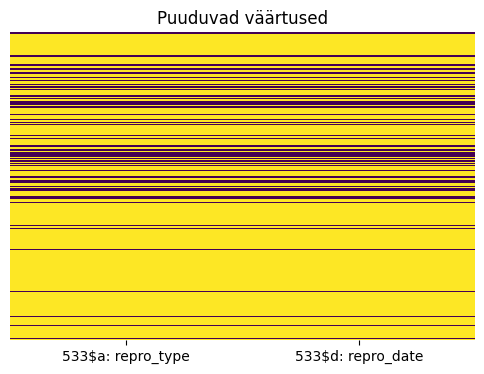

In [465]:
# nagu näha, siis kasutatakse neid kahte tulpa alati koos.
missing_values_heatmap(df)

In [468]:
### igaks juhuks topelkontroll, ega pole kirjeid, kus on täidetud nii 533$a kui 533$d
### nagu näha, siis 52 juhul on aasta puudu, aga see ei ole takistuseks
rows_with_only_533a = df[df['533$a'].notna() & df['533$d'].isna()]
rows_with_only_533d = df[df['533$a'].isna() & df['533$d'].notna()]
print("Kirjeid, kus ainult repro märge:", len(rows_with_only_533a))
print("Kirjeid, kus ainult repro aasta:", len(rows_with_only_533d))

Kirjeid, kus ainult repro märge: 52
Kirjeid, kus ainult repro aasta: 0


In [460]:
df["533$a"].value_counts()

Elektrooniline reproduktsioon                                                                                                 47183
Elektrooniline reproduktsioon; Elektrooniline reproduktsioon                                                                    307
aElektrooniline reproduktsioon                                                                                                    7
Elektrooniline reproduktsioon; Elektrooniline reproduktsioon; Elektrooniline reproduktsioon                                       5
 Elektrooniline reproduktsioon                                                                                                    3
Elektrooniline reproduktsioon. Tartu : Tartu Ülikooli Raamatukogu, 2015                                                           3
Elektrooniline reroduktsioon                                                                                                      2
9789916503232 (pdf)Elektrooniline reproduktsioon                            

In [473]:
df["533$d"].value_counts()[:20]

2022         12238
2023          8007
2019-2021     3992
2019          3240
2021          3074
2018          2286
2020          2155
2017          1931
2016          1790
2012          1279
2015           828
2011           706
2019.0         666
2018.0         630
2020.0         588
2014           571
2024           537
2023.0         534
2021.0         534
2013           518
Name: 533$d, dtype: int64

In [464]:
# 533$a saab muuta booleaniks (digiteeritud jah/ei)
# 533$d on seega sisuliselt digiteerimise aasta

#### 533$a

In [474]:
def clean_533a(entry):
    if type(entry) == str:
        return True
    else:
        return False

In [476]:
df["533$a_cleaned"] = df["533$a"].apply(clean_533a)

In [477]:
df

,533$a,533$d,533$a_cleaned
0,Elektrooniline reproduktsioon,2023,True
1,NaN,NaN,False
2,Elektrooniline reproduktsioon,2021,True
3,NaN,NaN,False
4,NaN,NaN,False
...,...,...,...
219990,NaN,NaN,False
219991,NaN,NaN,False
219992,NaN,NaN,False
219993,NaN,NaN,False


#### 533$d

In [545]:
match = re.match(r"\d{4}(\.0|\w+)", "2022.0")
match.string
match.string[:4]

'2022'

In [507]:
pattern_533d = re.compile(r"^(\d{4}(-\d{4})?)(\;\s\d{4}(-\d{4})?)*")

In [508]:
re.findall("\d{4}", "2012; 2013")

['2012', '2013']

In [588]:
def clean_533d(entry, pattern=pattern_533d, min_year=2000, max_year=2024):
    if type(entry) != str:
        entry = str(entry)
    match = re.match(pattern, entry)
    if match:
        year = match.string
        if re.match(r"\d{4}(\.0|\w+)", year):
            year = year[:4]
        return year
        

In [647]:
# näited
sample = df["533$d"].loc[df["533$d"].notna()].sample().values[0]
print(sample, "\t-\t", clean_533d(sample))

2019-2021 	-	 2019-2021


In [648]:
df["533$d_cleaned"] = df["533$d"].apply(clean_533d)

In [657]:
df.sample(10)

,533$a,533$d,533$a_cleaned,533$d_cleaned
54184,NaN,NaN,False,None
5315,NaN,NaN,False,None
138060,NaN,NaN,False,None
27424,NaN,NaN,False,None
182521,NaN,NaN,False,None
133148,NaN,NaN,False,None
177666,NaN,NaN,False,None
171960,NaN,NaN,False,None
134013,NaN,NaN,False,None
79213,NaN,NaN,False,None


### Sisu- ja žanrimärksõnad (650 a, 0; 655 a, 0)

In [660]:
df = df_main[["650$a", "650$0", "655$a", "655$0"]]

Täidetus:
650$a: subject_topic: 96 %
650$0: subject_topic_thesaurus: 95 %
655$a: subject_genre: 85 %
655$0: subject_genre_thesaurus: 58 %


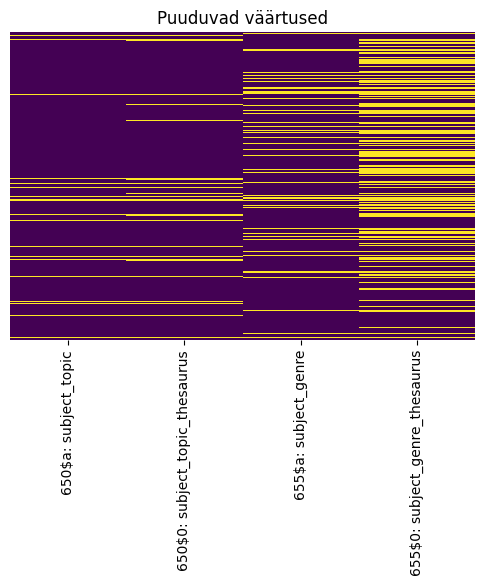

In [661]:
missing_values_heatmap(df)

In [662]:
df.sample(10)

,650$a,650$0,655$a,655$0
71666,jaekaubandus; kaubakäive; majandusanalüüs; kau...,https://ems.elnet.ee/id/EMS006025; https://ems...,NaN,NaN
174000,demokraatia; valitsusvälised organisatsioonid;...,https://ems.elnet.ee/id/EMS001665; https://ems...,aruanded; e-raamatud (vormimärksõna),https://ems.elnet.ee/id/EMS005972; https://ems...
65624,propaganda; töölisklass; talurahvas; proletari...,https://ems.elnet.ee/id/EMS005616; https://ems...,õpikud,https://ems.elnet.ee/id/EMS010408
209588,kodanike komiteed; iseseisvumine; ajalugu; kod...,https://ems.elnet.ee/id/EMS015923; https://ems...,mälestused,https://ems.elnet.ee/id/EMS009112
97868,rahandus; ministeeriumid,https://ems.elnet.ee/id/EMS019312; https://ems...,telefoniraamatud,NaN
13700,eesti keel; 5. klass; emakeel,https://ems.elnet.ee/id/EMS010261; https://ems...,töövihikud,NaN
52882,maaviljelus; mullateadus; kaugõpe,https://ems.elnet.ee/id/EMS007111; https://ems...,õppematerjalid,https://ems.elnet.ee/id/EMS007196
182783,usuõpetus; adventism,https://ems.elnet.ee/id/EMS022767; https://ems...,õppematerjalid,https://ems.elnet.ee/id/EMS007196
8015,tehnikakõrgkoolid; teaduskonnad; infotehnika,https://ems.elnet.ee/id/EMS006962; https://ems...,teatmikud,NaN
158662,suhtlemine; suhtlemispsühholoogia; inimsuhted;...,https://ems.elnet.ee/id/EMS021472; https://ems...,nõuanded,NaN


In [ ]:
### Märksõnade ja linkide dubleerimine tundub veidi mõttetu. Äkki hoopis tõstaks EMS IDd märksõnade järele nurksulgudesse (usuõpetus [022767]) ja lisaks seletuse dokumentatsiooni?

### Isikunime täiendkirje e. contributor (700)

In [674]:
df = df_main["700"].copy()

In [676]:
### näiteid; võib kontrollida, kas siin on kõik korras ja kas peaks täiendama. kas VIAFi tõstaksime samasse tulpa nt looksulgudesse või on mõni parem variant?
for val in df.loc[df.notna()].sample(10).values:
    print(val)

Kergandberg, Eerik (1953-) [toimetaja]; Saarsoo, Heldur (1931-1997) [toimetaja]
Kerge, Agnes (1910-1987) [tõlkija]; Matsulevitš, Tiit (1958-) [tõlkija]; Härm, Lilian (1927-2021) [illustreerija]
Kõreste, Andres [koostaja]
Tammiksaar, Erki (1969-) [autor]
Zimmermann, Silver (1988-) [tõlkija]; Tarum, Ülle (1955-) [toimetaja]
Rummo, Paul (1909-1981) [toimetaja]; Käosaar, Juhan (1909-1986) [eessõna autor]; Hoidre, Alo (1916-1993) [illustreerija]
Ederma, Bruno (1900-1976) [koostaja]; Tann, Nikolai (1890-1963) [koostaja]
Kure, Hels [tõlkija]; Teiter, Sille (1976-) [toimetaja]
Mardiste, Peep (1972-) [toimetaja]
Reek, Nikolai (1890-1942) [koostaja]; Luts, Alfred (1899-1991) [koostaja]


### Elektrooniline juurdepääs e. URI (856$u)

In [680]:
df = df_main["856$u"].copy().to_frame()

Täidetus:
856$u: electronic_access_URI: 37 %


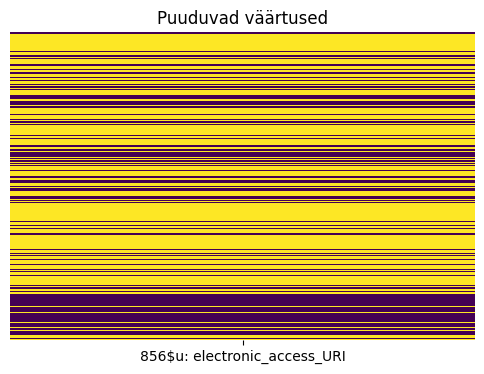

In [681]:
missing_values_heatmap(df)

In [683]:
### siin tundub kõik korras olevat
df.sample(10)

,856$u
17482,NaN
117560,NaN
29242,NaN
92236,NaN
136769,http://europa.eu.int/comm/energy/efficiency/do...
72166,http://hdl.handle.net/10062/88082
115746,http://www.digar.ee/id/nlib-digar:100021; http...
96183,NaN
208509,http://www.digar.ee/arhiiv/nlib-digar:602181
197448,http://www.digar.ee/arhiiv/nlib-digar:381906
